In [18]:
using PyCall
using PyPlot
using ForwardDiff, Flux
using LinearAlgebra
using Distributions
cmd = pyimport("cmdtools")

PyObject <module 'cmdtools' from '/Users/alex/Documents/code/cmdtools/src/cmdtools/__init__.py'>

In [19]:
N = 13

sys = cmd.systems.diffusion.DoubleWell(nx=N,beta=3, xlims=(-1.5,1.5))
Q = sys.Q.todense()
K = exp(Q*.5)

13×13 Array{Float64,2}:
 0.0526103    0.573021     0.326155     …  2.49444e-11  1.37704e-13
 0.013635     0.501216     0.408379        1.0095e-10   5.93551e-13
 0.00300378   0.15806      0.626987        1.24408e-9   7.93133e-12
 0.000731879  0.0482647    0.331448        2.88367e-8   2.01228e-10
 0.000161469  0.0126916    0.12371         7.97826e-7   6.13584e-9
 2.60507e-5   0.00237923   0.0302867    …  1.83401e-5   1.56663e-7
 2.6215e-6    0.000273146  0.00431456      0.000273146  2.6215e-6
 1.56663e-7   1.83401e-5   0.000346519     0.00237923   2.60507e-5
 6.13584e-9   7.97826e-7   1.75808e-5      0.0126916    0.000161469
 2.01228e-10  2.88367e-8   7.28882e-7      0.0482647    0.000731879
 7.93133e-12  1.24408e-9   3.55801e-8   …  0.15806      0.00300378
 5.93551e-13  1.0095e-10   3.21432e-9      0.501216     0.013635
 1.37704e-13  2.49444e-11  8.61195e-10     0.573021     0.0526103

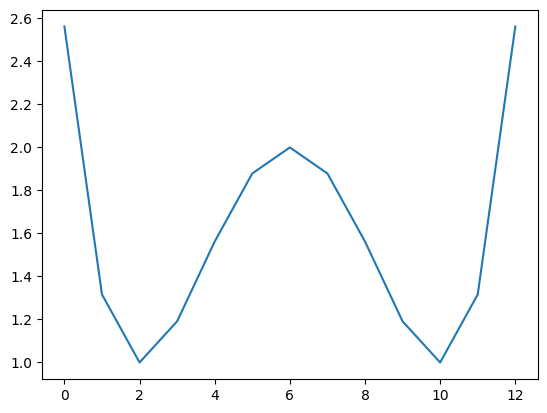

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15eb20760>

In [20]:
plot(sys.u')

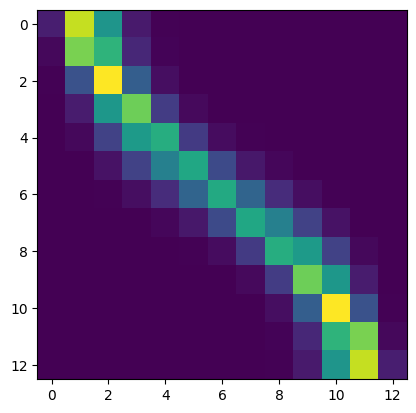

PyObject <matplotlib.image.AxesImage object at 0x15ec078b0>

In [21]:
imshow(K)

In [22]:
bnd = fill(NaN,size(K,1))
bnd[1+1] = 0
bnd[end-1] = 1

bndinds = findall(!isnan, bnd)
bnd

13-element Array{Float64,1}:
 NaN
   0.0
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   1.0
 NaN

In [23]:
function committor(K, b)
    A = copy(K)
    b = copy(b)
    for i in 1:length(b)
        if isnan(b[i])
            b[i] = 0
            A[i,i] -= 1
        else
            A[i,:].=0
            A[i,i]=1
        end
    end
    A\b
end

c = committor(K,bnd)

13-element Array{Float64,1}:
 0.01581438175296682
 0.0
 0.036884515255810546
 0.057081688970651585
 0.10515422503417002
 0.2400288788780668
 0.49999999999999917
 0.7599711211219315
 0.8948457749658282
 0.9429183110293469
 0.9631154847441882
 1.0
 0.9841856182470324

In [24]:
sample(x) = rand(Categorical(K[x,:]))

random_data(nx, ny) = let xs = [rand(1:N) for i in 1:nx]
    [(x, [sample(x) for i in 1:ny]) for x in xs]
end

linear_data(ny) = [(x, [sample(x) for i in 1:ny]) for x in 1:N]

data = linear_data(100)

13-element Array{Tuple{Int64,Array{Int64,1}},1}:
 (1, [2, 2, 2, 3, 3, 2, 3, 2, 3, 2  …  3, 2, 2, 2, 3, 1, 2, 2, 1, 2])
 (2, [3, 3, 3, 2, 3, 1, 2, 2, 3, 2  …  3, 2, 2, 2, 2, 3, 2, 2, 3, 3])
 (3, [3, 4, 3, 3, 4, 2, 3, 2, 3, 4  …  3, 2, 3, 2, 4, 3, 3, 4, 3, 3])
 (4, [4, 4, 4, 4, 3, 3, 4, 5, 4, 3  …  4, 3, 3, 4, 4, 4, 3, 2, 4, 5])
 (5, [3, 3, 5, 4, 4, 4, 6, 4, 5, 5  …  8, 5, 4, 3, 5, 6, 3, 5, 4, 4])
 (6, [7, 6, 5, 5, 4, 6, 5, 4, 6, 9  …  6, 7, 5, 6, 4, 7, 6, 6, 5, 5])
 (7, [8, 8, 9, 6, 9, 8, 10, 8, 8, 7  …  7, 10, 7, 7, 7, 8, 7, 6, 8, 7])
 (8, [8, 8, 7, 10, 7, 8, 8, 10, 7, 9  …  10, 10, 10, 9, 10, 9, 8, 8, 8, 8])
 (9, [10, 10, 10, 10, 10, 7, 9, 10, 11, 9  …  9, 9, 9, 10, 8, 10, 9, 9, 9, 8])
 (10, [11, 9, 10, 10, 10, 10, 10, 10, 10, 11  …  11, 10, 11, 11, 10, 12, 10, 11, 10, 10])
 (11, [11, 11, 11, 12, 11, 11, 12, 11, 12, 10  …  11, 11, 11, 11, 11, 10, 13, 11, 11, 10])
 (12, [11, 11, 12, 12, 11, 11, 11, 10, 12, 12  …  12, 11, 10, 12, 11, 12, 12, 13, 11, 12])
 (13, [12, 12, 12, 12, 12, 12, 1

In [25]:
loss(c, x, ys) = abs(mean(c(y) for y in ys) - c(x))

loss_batch(c, batch) = mean(loss(c,d...) for d in batch)

loss_batch (generic function with 1 method)

In [125]:
struct VectorModel
    c
    bnd
    bndinds
end

function (m::VectorModel)(x) 
    if x in m.bndinds
        m.bnd[x]
    else
        m.c[x]
    end
end

Flux.trainable(m::VectorModel) = (m.c,)

model1 = VectorModel(rand(N), bnd, bndinds)
model1(5)

0.09827992917014838

In [126]:
struct NNModel
    nn
    bnd
    bndinds
end

function (m::NNModel)(x) 
    if x in m.bndinds
        m.bnd[Int(x)]
    else
        m.nn([x])[1] # we work with scalars, nn with arrays
    end
end

Flux.trainable(m::NNModel) = (m.nn, )

model2 = NNModel(Chain(Dense(1,10), Dense(10,1)), bnd, bndinds)
model2(5)

function Base.show(m::NNModel)
    xs = 1:.1:N
    plot(xs, [m.nn([x]) for x in xs])
    plot(1:N, c)
end

In [34]:
error(x::Vector) = norm(x - c) / sqrt(length(x))
error(f) = error([f(x) for x in 1:N])

error (generic function with 2 methods)

In [45]:
function learn(model, nx=100, ny=100)


    errors = []
    losses = []

    opt = ADAM(0.1)

    data_batch = [linear_data(ny) for i in 1:nx] # 1 x sample 100 y sampes

    @time for d in data_batch
        ps = Flux.params(model)
        l, pb = Flux.pullback(ps) do
            loss_batch(model, d)
        end
        grad = pb(1)
        Flux.Optimise.update!(opt, ps, grad)
        push!(errors, error(model))
        push!(losses, l)
    end
    @show losses[end], errors[end]
    model, losses, errors
end

#model, losses, errors = learn(VectorModel(rand(N), bnd, bndinds))
model, losses, errors = learn(NNModel(Chain(Dense(1,10, σ), Dense(10,10, σ), Dense(10,1, σ)), bnd, bndinds))



25.809868 seconds (69.20 M allocations: 3.409 GiB, 4.02% gc time)
(losses[end], errors[end]) = (0.003965364507614423, 0.04504716610015154)


(NNModel(Chain(Dense(1, 10, σ), Dense(10, 10, σ), Dense(10, 1, σ)), [NaN, 0.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 1.0, NaN], [2, 12]), Any[0.10261903496888967, 0.09763060450553893, 0.09149458720133853, 0.07852373868227004, 0.06528484119818762, 0.05916347808562791, 0.05194124868282905, 0.04284771185654859, 0.03640097667391484, 0.03225285676379616  …  0.009911752007901672, 0.009189523669461224, 0.01280795938192079, 0.011453631831189767, 0.008266874686456649, 0.011143726497673648, 0.010726478237551278, 0.0124572266308734, 0.008062271831127305, 0.003965364507614423], Any[0.3618622388333034, 0.3401955895630759, 0.3122963164782945, 0.28521226617240464, 0.2783392454156193, 0.267649142175625, 0.21529557983541506, 0.14750754726063142, 0.2077317657015232, 0.07247052192580598  …  0.04722648205992363, 0.029693639263625837, 0.031087707790047887, 0.04347292484225937, 0.0799236702472029, 0.07067744168918759, 0.03495111670391113, 0.035916746611220296, 0.03857276210787671, 0.04504716610015154

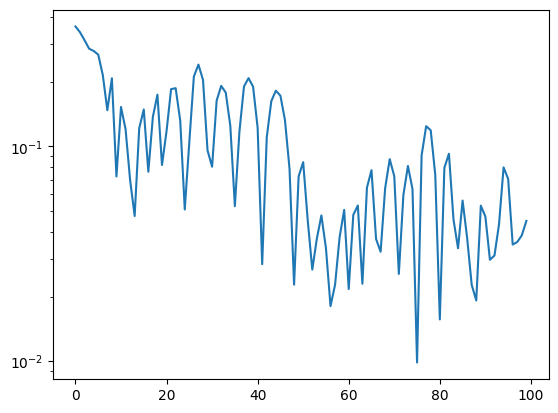

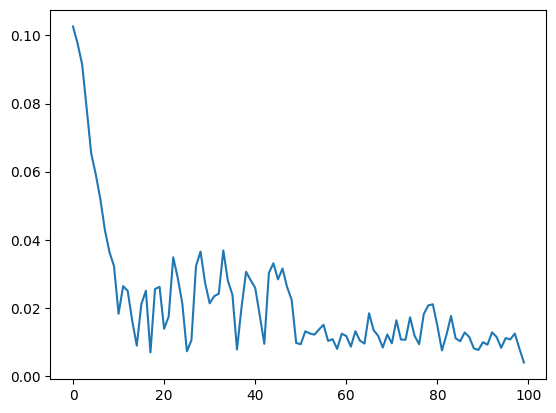

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15f70f250>

In [46]:
PyPlot.plot(errors)
PyPlot.yscale(:log)
figure()
plot(losses)
#yscale(:log)

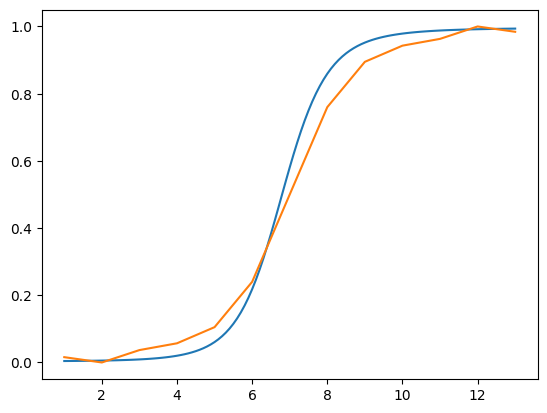

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15fae7370>

In [67]:
show(model)

# Comparing the loss estimate for different sample numbers on the true committor

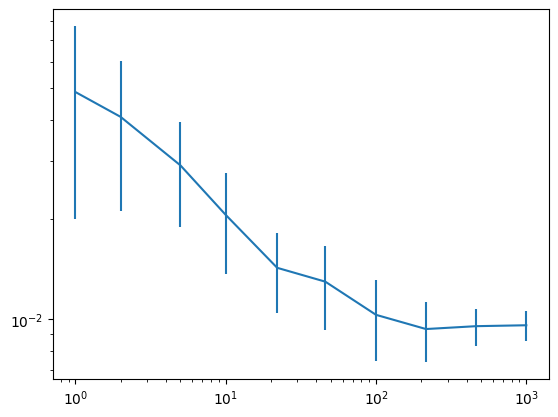

In [129]:
logspace(start, stop, num) = exp.(range(log(start), log(stop), length=num))

ms = round.(Int, logspace(1,1000, 10))
means = []
stds  = []

for m in ms 
    ls = [loss_batch(model, linear_data(m)) for i in 1:30]
    push!(means, mean(ls))
    push!(stds, std(ls))
end

errorbar(ms, means, yerr=stds)
yscale(:log)
xscale(:log)

In [130]:
truth = VectorModel(c, bnd, bndinds)
loss_batch(truth, linear_data(100000))

0.0032539428072816397

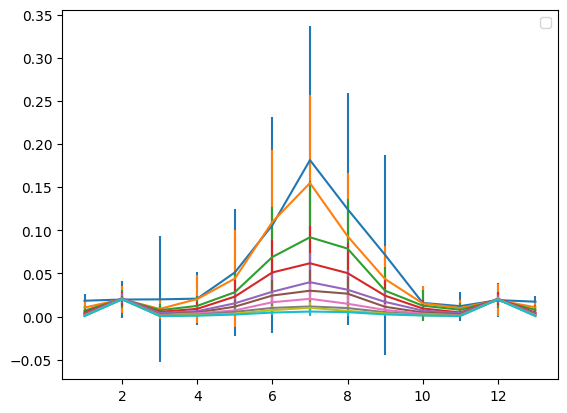

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x16037b3d0>

In [131]:
for m in ms
    t = hcat(([loss(truth, x, [sample(x) for y in 1:m]) for x in 1:13] for iter in 1:100)...)
    errorbar(1:N, mean(t, dims=2),yerr=std(t, dims=2)|>vec)
end
legend()